### Experiment 2: Molecular Classification using Graph-Level Features
In this notebook, we train two machine learning models simultaneously: one on the graph-level features and one on the graph structure. The model trained on the Graph Sturcture is a Graph Attention Network (GAT) that receives a Laplacian Matrix and generates a graph embedding. We combine the graph embeddings generated from these two strategies via a weight parameter. During each training step, we compute loss and perform a backward pass on both models.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


FOLDERNAME = "224W Final Project"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/224W Final Project


## Download Packages and Data

In [2]:
! wget http://ogb-data.stanford.edu/data/lsc/pcqm4m-v2-train.sdf.tar.gz
! md5sum pcqm4m-v2-train.sdf.tar.gz # fd72bce606e7ddf36c2a832badeec6ab
! tar -xf pcqm4m-v2-train.sdf.tar.gz # extracted pcqm4m-v2-train.sdf

--2023-12-15 05:38:44--  http://ogb-data.stanford.edu/data/lsc/pcqm4m-v2-train.sdf.tar.gz
Resolving ogb-data.stanford.edu (ogb-data.stanford.edu)... 171.64.75.57
Connecting to ogb-data.stanford.edu (ogb-data.stanford.edu)|171.64.75.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1559712928 (1.5G) [application/x-gzip]
Saving to: ‘pcqm4m-v2-train.sdf.tar.gz.22’

pcqm4m-v2-train.sdf 100%[===================>]   1.45G  24.1MB/s    in 53s     

2023-12-15 05:39:36 (28.2 MB/s) - ‘pcqm4m-v2-train.sdf.tar.gz.22’ saved [1559712928/1559712928]

fd72bce606e7ddf36c2a832badeec6ab  pcqm4m-v2-train.sdf.tar.gz


In [3]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.5 MB/s eta 0:00:00


In [4]:
from rdkit import Chem

suppl = Chem.SDMolSupplier('pcqm4m-v2-train.sdf')
# for idx, mol in enumerate(suppl):
#     print(f'{idx}-th rdkit mol obj: {mol}')

In [5]:
! pip install ogb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=c61502e5340bc74cf1305c301f5867016a60d0f7da8fefce029d11a251ff9ec4
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [6]:
from ogb.lsc import PCQM4Mv2Dataset
dataset = PCQM4Mv2Dataset(root = FOLDERNAME, only_smiles = True)

#See one molecule in the dataset
i = 1234
print(dataset[i]) # ('CC(NCC[C@H]([C@@H]1CCC(=CC1)C)C)C', 6.811009678015001)

('CC(NCC[C@H]([C@@H]1CCC(=CC1)C)C)C', 6.811009678015001)


In [7]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.7 MB/s eta 0:00:00


In [8]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=495091 sha256=cee59f46e6e8a16378cd9bee04102d45b8b0dce015b93f94d695c197a9fdd572
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1035675 sha256=c4d38817aa286125ec726694705507439fc67c0b3daee434baf999192fabb6f1
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Succe

In [9]:
from ogb.utils import smiles2graph
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw

In [11]:
print(len(dataset))

3746620


# Preprocess Data: Generate Graphs from the strings that represent molecules.
For example, the string `"O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C"`represents a molecule.

In [12]:
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from torch.utils.data import Dataset, DataLoader
#Converting the smiles strings to graphs

#dataset: a PCQM4Mv2Dataset of strings
print(dataset[0]) # ('O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C', 3.0476751256)
desired_size = 40000 # A smaller dataset trains faster
smaller_dataset = list(dataset)[:desired_size]
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)

    try:
        AllChem.EmbedMolecule(mol, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol)
    except ValueError:  # handles unregcognized charge states
        return None

    adj = rdmolops.GetAdjacencyMatrix(mol)
    features = torch.tensor(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512), dtype=torch.float32)
    nonzero_indices = np.array(adj.nonzero(), dtype=np.long).T
    edge_index_tensor = torch.tensor(nonzero_indices, dtype=torch.long).t().contiguous()
    return {"x": features, "edge_index": edge_index_tensor}

graph_data = [(smiles_to_graph(data), torch.tensor(label, dtype=torch.float32)) for data, label in smaller_dataset if smiles_to_graph(data) is not None]



('O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C', 3.0476751256)


<ipython-input-12-e25638d24d5c>:32: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nonzero_indices = np.array(adj.nonzero(), dtype=np.long).T
[06:14:03] UFFTYPER: Unrecognized atom type: S_5+4 (9)
[06:14:03] UFFTYPER: Unrecognized atom type: S_5+4 (9)
[06:14:03] UFFTYPER: Unrecognized atom type: S_5+4 (9)
[06:14:03] UFFTYPER: Unrecognized atom type: S_5+4 (9)
[06:16:16] UFFTYPER: Unrecognized cha

In [13]:
#Finding the median label so that we can decide the dividing line between soluble and insoluble
label_tensors = [data[1] for data in graph_data]
all_labels = torch.stack(label_tensors)
median_value = torch.median(all_labels).item()

print("Median Label:", median_value)

Median Label: 5.257239818572998


## Generate train_loader and valid_loader from the data

In [14]:
#Loading the Data
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader
from tqdm.notebook import tqdm

class GraphDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            # If idx is a scalar, return a single item
            graph_item = self.data[idx]
            x = graph_item[0]['x']
            edge_index = graph_item[0]['edge_index']
            label = graph_item[1]
            return {'x': x, 'edge_index': edge_index}, label
        elif isinstance(idx, (list, np.ndarray)):
            # If idx is a list or numpy array, return a batch of items
            batch_data = [self.data[i] for i in idx]
            x_batch = [item[0]['x'] for item in batch_data]
            edge_index_batch = [item[0]['edge_index'] for item in batch_data]
            label_batch = [item[1] for item in batch_data]
            data_dicts = [{'x': x, 'edge_index': edge_index} for x, edge_index in zip(x_batch, edge_index_batch)]
            # Zip data_dicts with label_batch and return a list of tuples
            data_tuples = list(zip(data_dicts, label_batch))
            return data_tuples
        else:
            raise TypeError("Unsupported index type")
        return {'x': x, 'edge_index': edge_index}, label
    def get_idx_split(self, test_size=0.2, random_state=None):
        # Assuming self.data is a list
        indices = list(range(len(self.data)))

        # Split the indices into training and validation sets
        train_indices, valid_indices = train_test_split(indices, test_size=test_size, random_state=random_state)

        # Return a dictionary with keys "train" and "valid"
        return {"train": train_indices, "valid": valid_indices}


# Instantiate your dataset
print("graph_data", graph_data[0])
graph_dataset = GraphDataset(graph_data)

# Create a DataLoader
batch_size = 64  # You can adjust this based on your needs
dataloader = DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)
split_idx = graph_dataset.get_idx_split()
train_loader = DataLoader(graph_dataset[split_idx["train"]], batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(graph_dataset[split_idx["valid"]], batch_size=32, shuffle=False, num_workers=0)

graph_data ({'x': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#The Model Applied to Graph Features
This is a defintion of a classic machine learning model used to generate graph embeddings from graph features. It will the trained later, in conjunction with the Graph Attention Model (GAT).

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor


# Define the model to process the graph features. This model will be trained jointly
# with a model trained on the graph structure later on in the colab.
class GraphFeaturesModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(GraphFeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
input_size = 512
hidden_size = 256
dropout_rate = 0.2
model_graph_features = GraphFeaturesModel(input_size, hidden_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_graph_features.parameters(), lr=0.001)


# Training and Evaluting the Model
This is the most important code block of the notebook. Here we train and evaluate both machine learning models: the Graph Attention Model for the graph structure and the classic one for the graph-level features. Each training step involves a forward pass and a backward pass for each model. The code below also presents the accuracy and loss curves.

Validation Accuracy: 0.7652284263959391


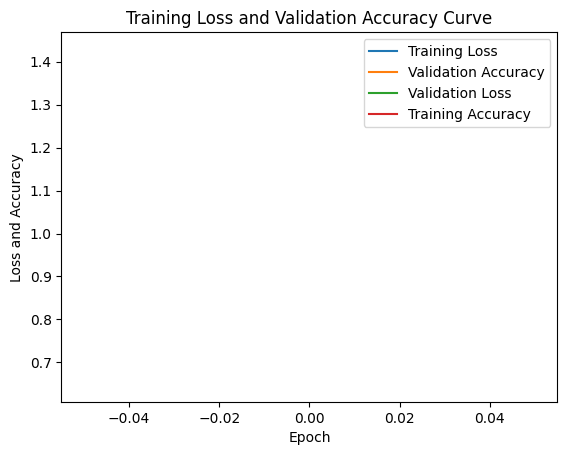

Validation Accuracy: 0.8134517766497462


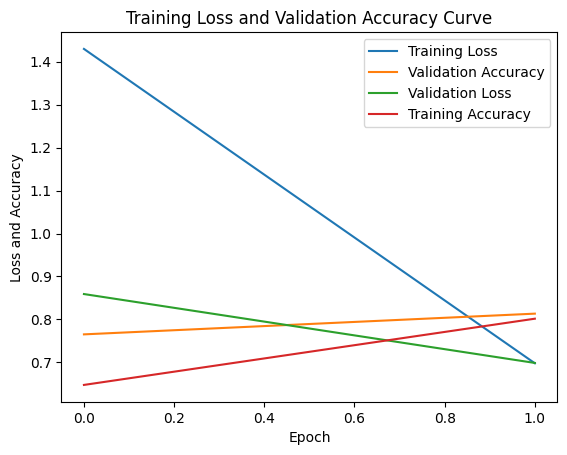

Validation Accuracy: 0.8210659898477157


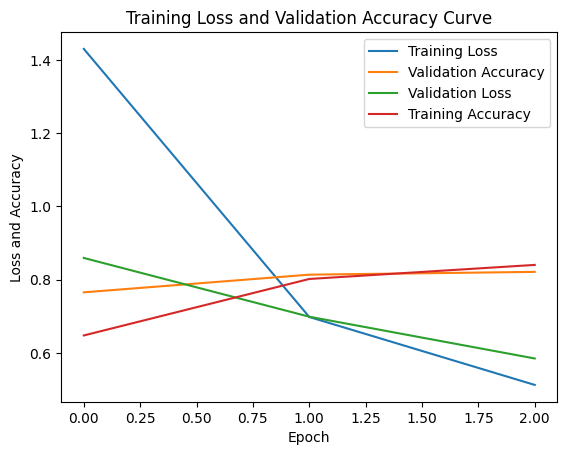

Validation Accuracy: 0.8185279187817259


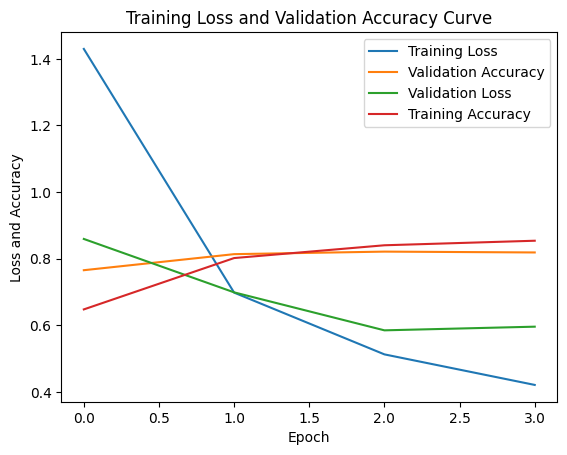

Validation Accuracy: 0.7956852791878173


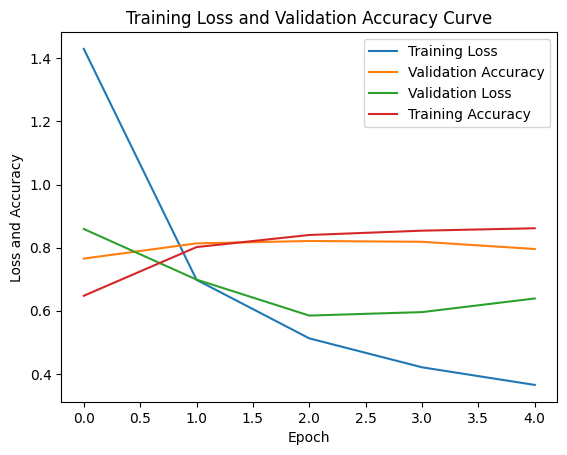

Validation Accuracy: 0.8451776649746193


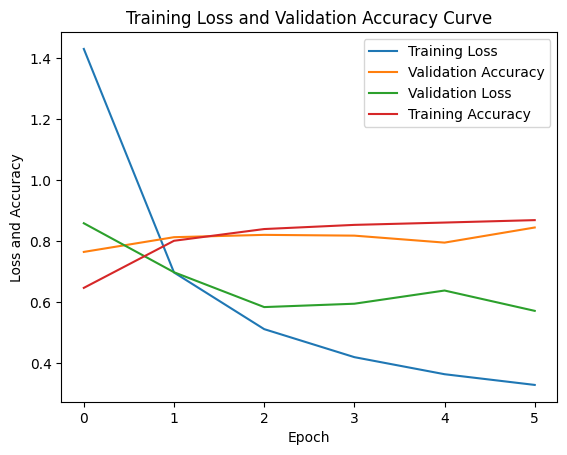

Validation Accuracy: 0.8527918781725888


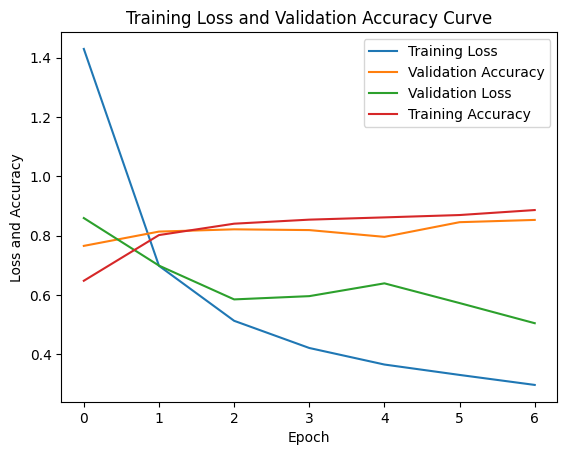

Validation Accuracy: 0.8045685279187818


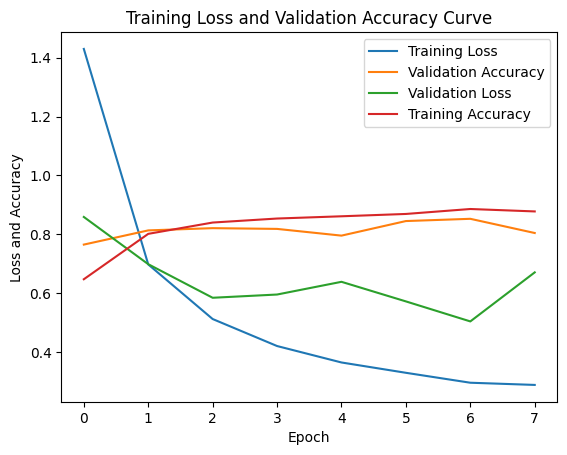

Validation Accuracy: 0.8312182741116751


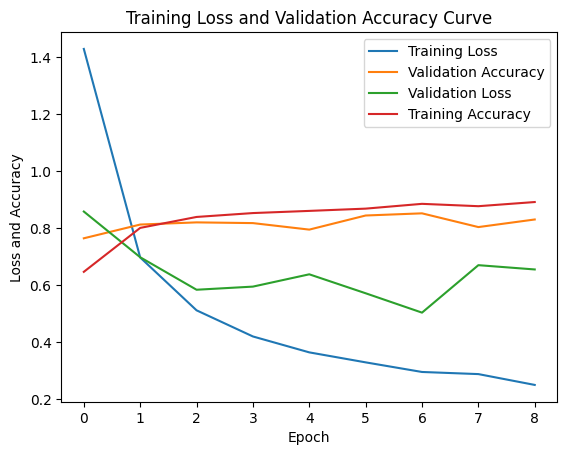

Validation Accuracy: 0.8527918781725888


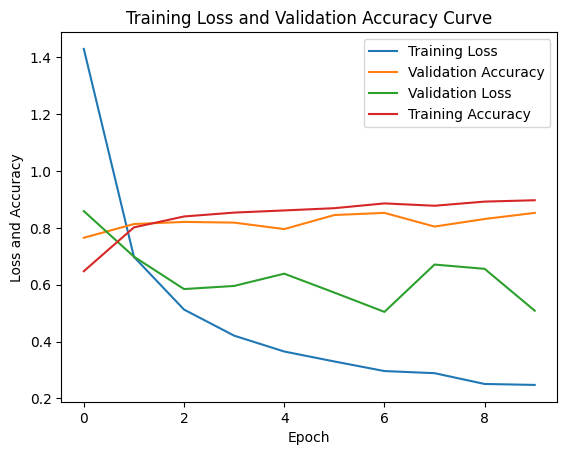

Validation Accuracy: 0.8286802030456852


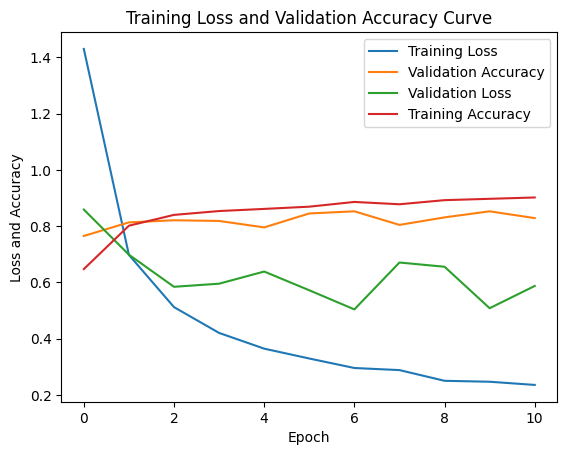

Validation Accuracy: 0.8388324873096447


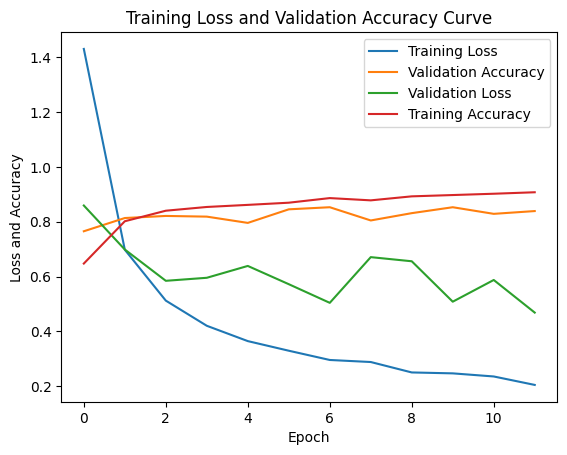

Validation Accuracy: 0.8413705583756346


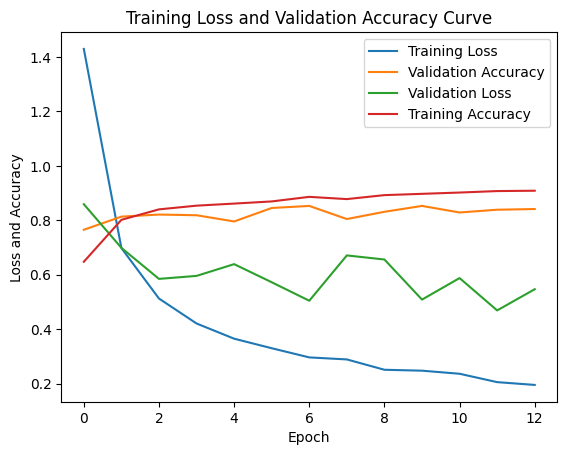

Validation Accuracy: 0.8553299492385786


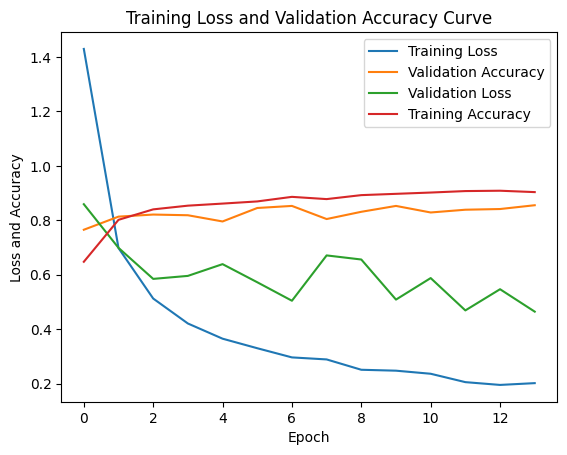

Validation Accuracy: 0.8565989847715736


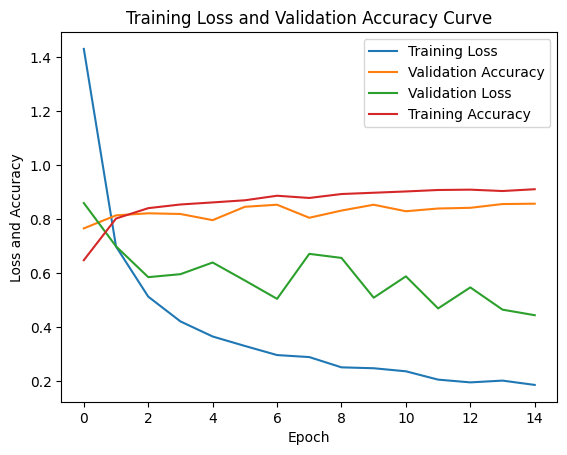

Validation Accuracy: 0.8654822335025381


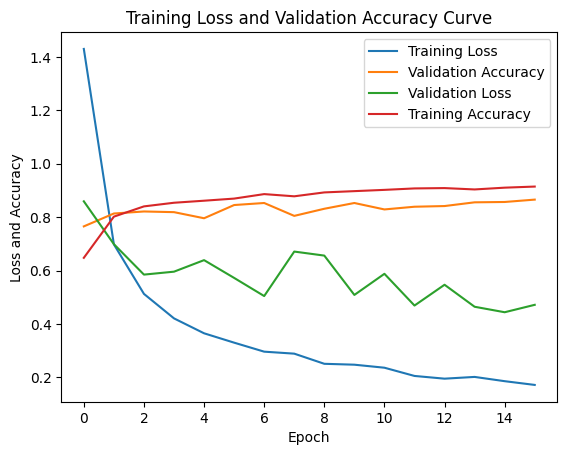

Validation Accuracy: 0.8286802030456852


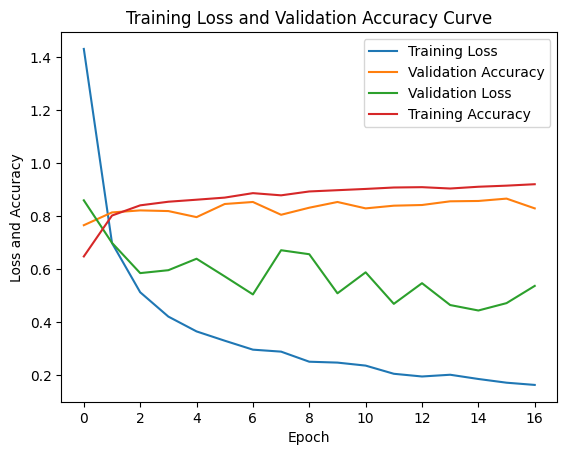

Validation Accuracy: 0.8692893401015228


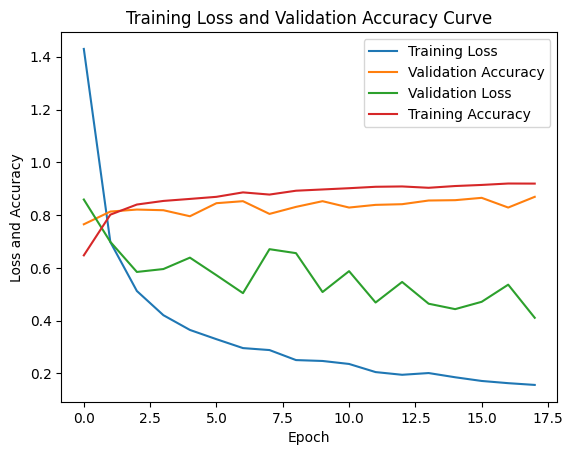

Validation Accuracy: 0.8591370558375635


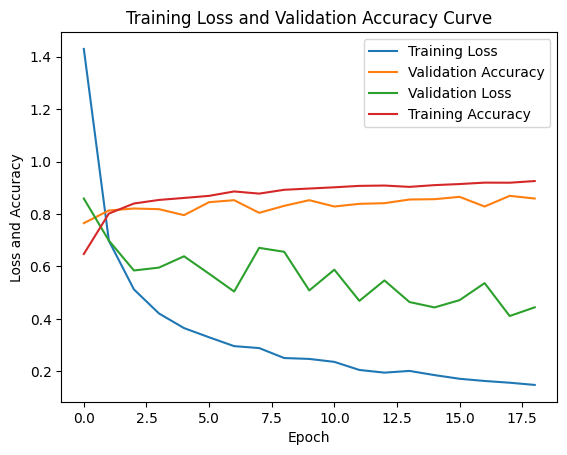

Validation Accuracy: 0.8642131979695431


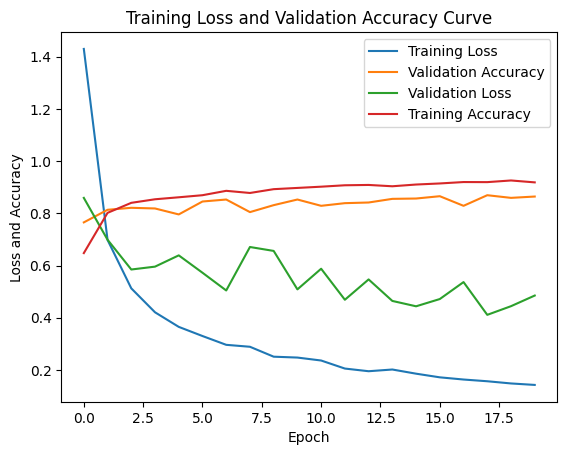

Validation Accuracy: 0.8591370558375635


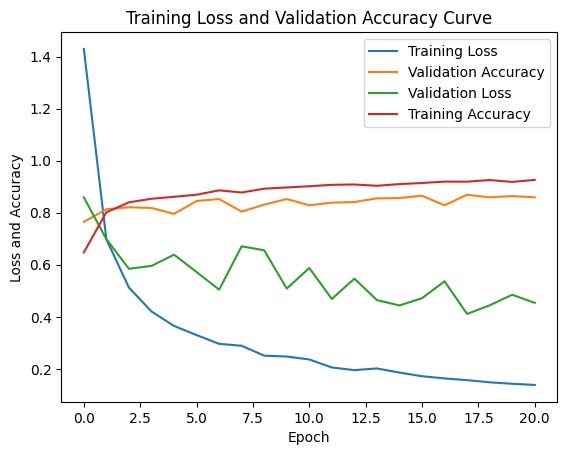

Validation Accuracy: 0.866751269035533


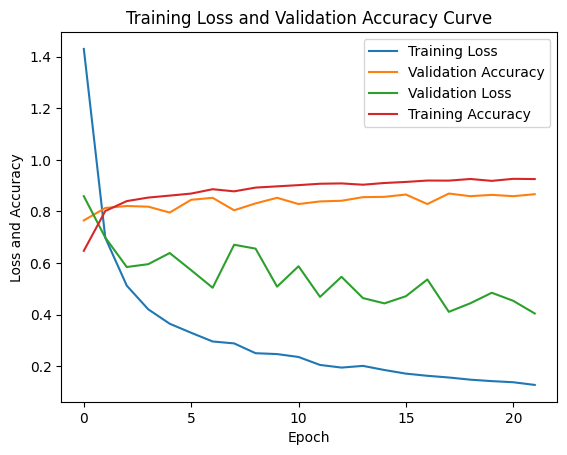

Validation Accuracy: 0.881979695431472


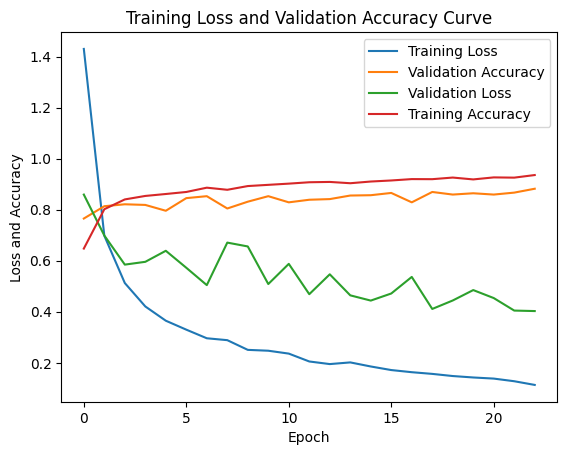

Validation Accuracy: 0.8629441624365483


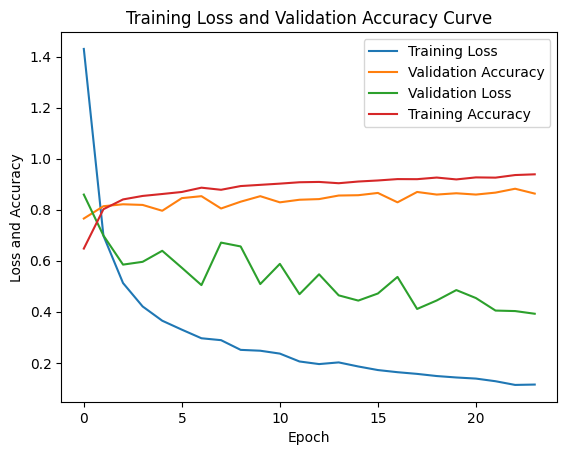

Validation Accuracy: 0.868020304568528


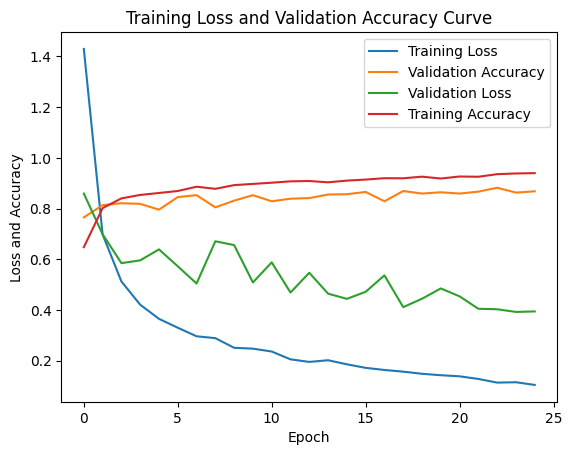

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch_sparse import SparseTensor
from sklearn.metrics import r2_score
#This cell contains the most important code for this project.
# It jointly trains the models for graph strcuture and graph features, as well
# as the weight parameter that balances the resulting tensors. It also computes
#accuracy over the epochs.


# In this code block, we define the GAT model to train on a Laplacian matrix
# that represents the node connectivity.
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, num_heads=1):
        super(GATLayer, self).__init__()
        self.gat = GATConv(
            in_channels=in_features,
            out_channels=out_features,
            heads=num_heads,
            concat=True,
            dropout=0.6
        )
        self.batch_norm = nn.BatchNorm1d(out_features * num_heads)

    def forward(self, x, edge_index, laplacian_matrix):
        # Apply Laplacian matrix
        lap_x = laplacian_matrix @ x

        # GAT convolution
        x = self.gat(lap_x, edge_index)
        x = F.relu(x)
        x = self.batch_norm(x)

        return x

class GraphNetGlobalPooling(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GraphNetGlobalPooling, self).__init__()
        self.gat1 = GATLayer(input_size, hidden_size, num_heads=4)
        self.gat2 = GATLayer(hidden_size * 4, output_size, num_heads=1)
        self.weight = nn.Parameter(torch.Tensor(1))

    def forward(self, x, edge_index):
        num_nodes = edge_index.max().item() + 1
        x = model_graph_features(x)

        #Creating Laplacian Matrix
        adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
        deg_matrix = adj_matrix.sum(dim=1).to_dense()
        laplacian_matrix = torch.diag(deg_matrix.squeeze()) - adj_matrix.to_dense()

        eigenvalues, eigenvectors = torch.linalg.eigh(laplacian_matrix, UPLO='U')
        sorted_indices = torch.argsort(eigenvalues)
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        k = 5
        top_k_eigenvectors = laplacian_matrix #sorted_eigenvectors[:, :]
        #uncomment the sorted_eigenvectors part above to activate the SignNet-enhanced laplacian matrix


        node_features = torch.randn([num_nodes, input_size])
        x1 = self.gat1(node_features, edge_index, top_k_eigenvectors)
        x2 = self.gat2(x1, edge_index, top_k_eigenvectors)
        x2 = torch.mean(x2, dim=0, keepdim=True)

        #Combining the two embeddings using the learned weight parameter
        weighted_average = self.weight * x + (1 - self.weight) * x2
        return weighted_average


#Intializing the two models that will train together
input_size = 512
hidden_size = 64
output_size = 1  # Regression task, single output
model_graph_structure = GraphNetGlobalPooling(input_size, hidden_size, output_size)
criterion_structure = nn.MSELoss()
optimizer_structure = torch.optim.Adam(model_graph_structure.parameters(), lr=0.001)

input_size = 512
hidden_size = 256
dropout_rate = 0.2
model_graph_features = GraphFeaturesModel(input_size, hidden_size, dropout_rate)
criterion_features = nn.MSELoss()
optimizer_features = torch.optim.Adam(model_graph_features.parameters(), lr=0.001)
losses = []
training_accuracies = []
val_losses = []


# Training loop
num_epochs = 25
accuracies = []

for epoch in range(num_epochs):

    epoch_loss = 0
    right_train = 0
    total_train = 0
    epoch_valid_loss = 0
    for data, label in train_loader.dataset:
        x = data['x']
        #loss step for graph_structure model
        label_pred = model_graph_structure(x, data['edge_index'])
        loss = criterion_structure(label_pred, label.float())
        optimizer_structure.zero_grad()
        loss.backward()
        optimizer_structure.step()

        # loss step for graph_features model
        label_pred = model_graph_features(x)
        loss = criterion_features(label_pred, label.float())
        optimizer_features.zero_grad()
        loss.backward()
        optimizer_features.step()
        epoch_loss += loss.item()

        #training accuracy
        label_pred = model_graph_structure(x, data['edge_index'])
        y_train_pred = 1 if label_pred > median_value else 0
        y_train = 1 if label > median_value else 0
        right_train += y_train == y_train_pred
        total_train += 1


    training_accuracy = right_train / total_train
    training_accuracies.append(training_accuracy)
    losses.append(epoch_loss / len(train_loader.dataset))
    model_graph_structure.eval()
    with torch.no_grad():
      total = 0
      right = 0
      y_true_valid = []
      y_pred_valid = []
      for data, label in valid_loader.dataset:
          x = data['x']
          edge_index = data['edge_index']
          #preparing for validation R2
          label_pred = model_graph_structure(x, edge_index)
          y_true_valid.append(label)
          y_pred_valid.append(label_pred)

          #validation accuracy
          label_pred = 1 if label_pred[0][0] > median_value else 0
          y_test = 1 if label > median_value else 0
          total += 1
          right += y_test == label_pred

          #validation loss
          label_pred = model_graph_features(data['x'])
          loss = criterion_features(label_pred, label.float())
          epoch_valid_loss += loss.item()
      # r2_valid = r2_score(y_true_valid, y_pred_valid)
      # print(f"R^2 (Validation): {r2_valid}")

      val_losses.append(epoch_valid_loss/len(valid_loader.dataset))
      accuracy = right / total
      accuracies.append(accuracy)
      print("Validation Accuracy:", accuracy)
      # Plot the loss curve
      plt.plot(losses, label='Training Loss')
      plt.plot(accuracies, label='Validation Accuracy')
      plt.plot(val_losses, label='Validation Loss')
      plt.plot(training_accuracies, label='Training Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Loss and Accuracy')
      plt.title('Training Loss and Validation Accuracy Curve')
      plt.legend()
      plt.show()
      # Evaluation loop


In [23]:
y_true_valid = []
y_pred_valid = []
for data, label in valid_loader.dataset:
    x = data['x']
    edge_index = data['edge_index']
    #preparing for validation R2
    label_pred = model_graph_structure(x, edge_index)
    y_true_valid.append(label)
    y_pred_valid.append(label_pred.detach().numpy().item())


r2_valid = r2_score(y_true_valid, y_pred_valid)
print(f"R^2 (Validation): {r2_valid}")

R^2 (Validation): 0.7488168598093374


In [ ]:
print("accuracies", accuracies)
print("losses", losses)